In [3]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import ndimage
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score

from utils import *
from model_FCNN import generate_model


In [102]:
from importlib import reload

import keras
reload(keras)
from keras import backend as K

import utils
reload(utils)
from utils import *

import model_FCNN
reload(model_FCNN)
from model_FCNN import generate_model

import callback_custom
reload(callback_custom)

<module 'callback_custom' from '/home/kumamon/src/segDGM_3DCNN/callback_custom.py'>

# Problem configuration

In [95]:
num_classes = 11
num_channel = 1

# K-fold validation (K=5)
n_training = 16
n_test = 4

idxs_training = list(range(1, 1+16))
idxs_test = list(range(17, 17+4))

patience = 5
model_filename = 'models/outrun_step_{}.h5'
csv_filename = 'log/outrun_step_{}.cvs'

nb_epoch = 40
validation_split = 0.20
monitor = 'val_loss'#'val_categorical_accuracy'

class_mapper = {0:0}
class_mapper.update({ i+1:i for i in range(1, 1+10) })
class_mapper_inv = {0:0}
class_mapper_inv.update({ i:i+1 for i in range(1, 1+10) })

matrix_size = (160, 220, 48)

extraction_step = (3, 3, 3)
#extraction_step = (9, 9, 3)

segment_size = (27, 27, 21)
core_size = (9, 9, 3)

# Architecture

# 1. Initial segmentation

## 1.1 Read data

In [12]:
QSM_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
MAG_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
R2S_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
label_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_training):
    QSM_train[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_train[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_train[i, :, :, :] = read_data(case_idx, 'R2S')
    label_train[i, :, :, :] = read_data(case_idx, 'label')

In [13]:
#data_train = np.stack((QSM_train, MAG_train, R2S_train), axis = 1)
data_train = np.stack((QSM_train,), axis = 1)

In [14]:
QSM_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
MAG_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
R2S_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
label_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_test):
    QSM_test[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_test[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_test[i, :, :, :] = read_data(case_idx, 'R2S')
    label_test[i, :, :, :] = read_data(case_idx, 'label')

In [15]:
#data_test = np.stack((QSM_test, MAG_test, R2S_test), axis = 1)
data_test = np.stack((QSM_test,), axis = 1)

## 1.2 Pre-processing

In [16]:
## Intensity normalisation (zero mean and unit variance)
input_mean = 127.0
input_std = 128.0
data_train = (data_train - input_mean) / input_std
data_test = (data_test - input_mean) / input_std

# Map class label
tmp = np.copy(label_train)
for class_idx in class_mapper:
    label_train[tmp == class_idx] = class_mapper[class_idx]
tmp = np.copy(label_test)
for class_idx in class_mapper:
    label_test[tmp == class_idx] = class_mapper[class_idx]
del tmp

In [19]:
label_train.max()

10.0

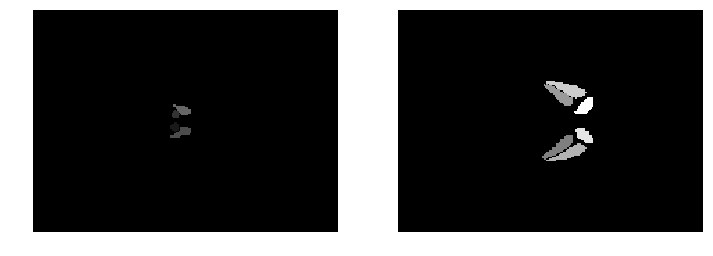

In [20]:
plots(np.squeeze(label_train[0,:,:,[29,25]]), scale = (0, 10))

## 1.3 Data preparation

In [62]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((10850, 1, 27, 27, 21), (10850, 243, 11))

In [113]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

## 1.4 Configure callbacks

In [65]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Early stopping for reducing over-fitting risk
stopper = EarlyStopping(patience=patience, monitor='val_categorical_accuracy')

# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    monitor='val_categorical_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')

callbacks = [checkpointer, csv_logger, stopper]

In [29]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=patience, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=1e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction]

In [115]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('1'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

## 1.5 Training

In [116]:
seed = 47
np.random.seed(seed)

# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

K.set_value(model.optimizer.lr, 1e-3)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 8680 samples, validate on 2170 samples
Epoch 1/40
8680/8680 [==============================] - 55s 6ms/step - loss: 0.6797 - categorical_accuracy: 0.8149 - val_loss: 0.5419 - val_categorical_accuracy: 0.8283
Epoch 2/40
8680/8680 [==============================] - 52s 6ms/step - loss: 0.2808 - categorical_accuracy: 0.9025 - val_loss: 0.6537 - val_categorical_accuracy: 0.8613
Epoch 3/40
8680/8680 [==============================] - 53s 6ms/step - loss: 0.1363 - categorical_accuracy: 0.9453 - val_loss: 0.5097 - val_categorical_accuracy: 0.8799
Epoch 4/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.1027 - categorical_accuracy: 0.9581 - val_loss: 0.4595 - val_categorical_accuracy: 0.9025
Epoch 5/40
8672/8680 [============================>.] - ETA: 0s - loss: 0.0765 - categorical_accuracy: 0.9683Epoch 00005: val_loss did not improve
0.001 1e-05
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0765 - categorical_accuracy: 0.9683 - val_loss: 0

## 1.6 Classification

In [117]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format(1))

In [118]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

2170/2170 [==============================] - 2s 1ms/step


[0.45949072467017282, 0.90250119833352926]

In [119]:
len_patch = extract_patches(read_data(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [120]:
segmentations_train = []

for i_case, case_idx in enumerate(idxs_training):

    print(case_idx)
    input_train = data_train[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_train[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_train = segmentations_train + [segmentation]
    
segmentations_train = np.stack(segmentations_train, axis=0)

1
3300/3300 [==============================] - 3s 930us/step
2
3300/3300 [==============================] - 3s 803us/step
3
3300/3300 [==============================] - 3s 773us/step
4
3300/3300 [==============================] - 3s 785us/step
5
3300/3300 [==============================] - 3s 774us/step
6
3300/3300 [==============================] - 3s 777us/step
7
3300/3300 [==============================] - 3s 770us/step
8
3300/3300 [==============================] - 3s 780us/step
9
3300/3300 [==============================] - 3s 792us/step
10
3300/3300 [==============================] - 3s 778us/step
11
3300/3300 [==============================] - 3s 786us/step
12
3300/3300 [==============================] - 3s 790us/step
13
3300/3300 [==============================] - 3s 782us/step
14
3300/3300 [==============================] - 3s 795us/step
15
3300/3300 [==============================] - 3s 785us/step
16
3300/3300 [==============================] - 3s 795us/step


In [78]:
segmentations_train.max()

10.0

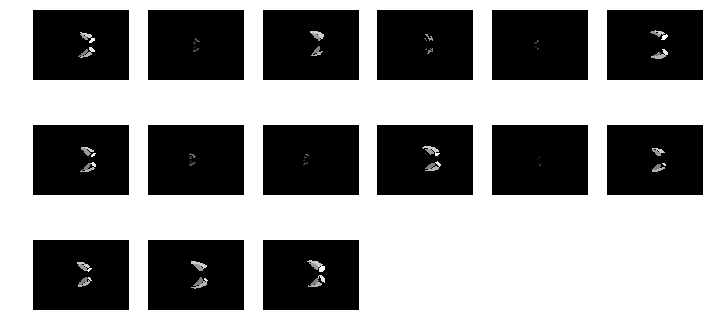

In [46]:
plots(np.squeeze(label_train[0:15,:,:,25]), rows=3, scale = (0, 10))

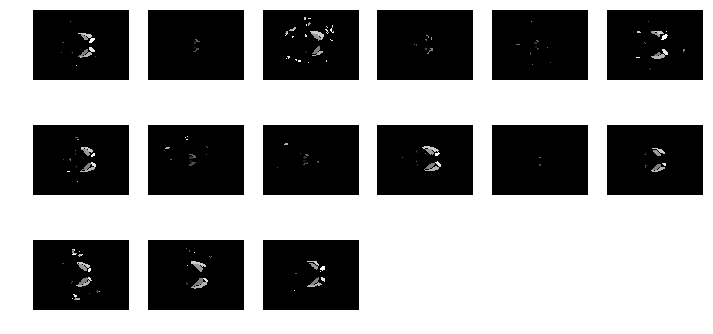

In [121]:
plots(np.squeeze(segmentations_train[0:15,:,:,25]), rows=3, scale = (0, 10))

## 1.7 Check false-positive

In [125]:
idx_fpos = (label_train == 0) & (segmentations_train != 0);

In [126]:
mask_fpos = np.zeros(label_train.shape, dtype=precision_global)
mask_fpos[idx_fpos == True] = 1

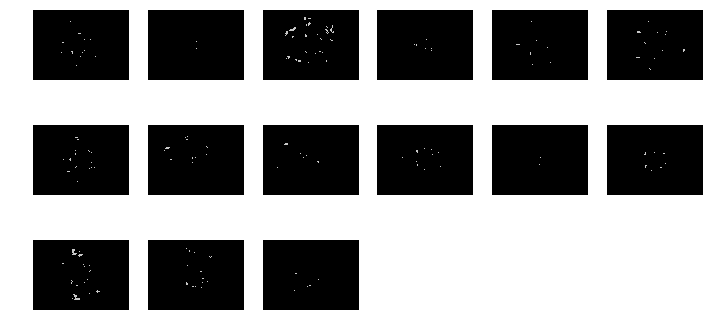

In [127]:
plots(200*(np.squeeze(mask_fpos[0:15,:,:,25])), rows=3)

# 2 Fine-tuning

## 2.2 Rebuild training dataset

In [128]:
del x_train, y_train

In [129]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size, mask_fpos)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((34305, 1, 27, 27, 21), (34305, 243, 11))

In [130]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

In [131]:
save_array('tmp/x_train.bc', x_train)
save_array('tmp/y_train.bc', y_train)

In [4]:
x_train = load_array('tmp/x_train.bc')
y_train = load_array('tmp/y_train.bc')

## 2.3 Regenerate model

In [58]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Early stopping for reducing over-fitting risk
stopper = EarlyStopping(patience=patience, monitor='val_categorical_accuracy')

# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    monitor='val_categorical_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')

callbacks = [checkpointer, csv_logger, stopper]

In [41]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=patience, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=1e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction]

In [132]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('2'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

In [133]:
# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

# Load optimized weights
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 27444 samples, validate on 6861 samples
Epoch 1/40
27444/27444 [==============================] - 170s 6ms/step - loss: 0.0260 - categorical_accuracy: 0.9895 - val_loss: 0.3369 - val_categorical_accuracy: 0.9566
Epoch 2/40
27444/27444 [==============================] - 168s 6ms/step - loss: 0.0158 - categorical_accuracy: 0.9936 - val_loss: 0.3807 - val_categorical_accuracy: 0.9564
Epoch 3/40
27424/27444 [============================>.] - ETA: 0s - loss: 0.0120 - categorical_accuracy: 0.9952Epoch 00003: val_loss did not improve
0.0001 1e-05
27444/27444 [==============================] - 169s 6ms/step - loss: 0.0120 - categorical_accuracy: 0.9952 - val_loss: 0.3828 - val_categorical_accuracy: 0.9581
Epoch 4/40
27444/27444 [==============================] - 170s 6ms/step - loss: 0.0093 - categorical_accuracy: 0.9963 - val_loss: 0.3798 - val_categorical_accuracy: 0.9581
Epoch 5/40
27424/27444 [============================>.] - ETA: 0s - loss: 0.0070 - categorical_accuracy: 0.9973 

In [134]:
# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format('2'))

In [135]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

6861/6861 [==============================] - 6s 851us/step


[0.33092002472511617, 0.95755856075538459]

In [136]:
segmentations_test = []

for i_case, case_idx in enumerate(idxs_test):

    print(case_idx)
    input_test = data_test[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_test[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_test = segmentations_test + [segmentation]
    
segmentations_test = np.stack(segmentations_test, axis=0)

17
3300/3300 [==============================] - 3s 947us/step
18
3300/3300 [==============================] - 3s 762us/step
19
3300/3300 [==============================] - 3s 761us/step
20
3300/3300 [==============================] - 3s 771us/step


In [137]:
segmentations_test.max()

10.0

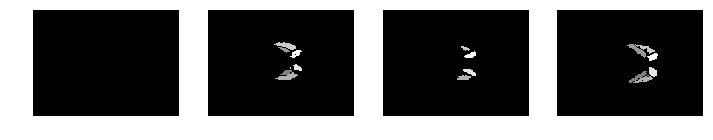

In [139]:
plots(np.squeeze(label_test[:,:,:,22]), rows=1, scale = (0, 10))

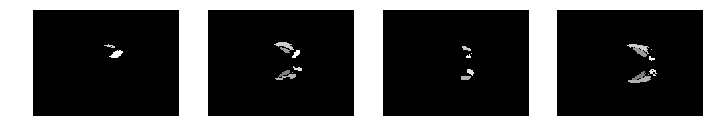

In [140]:
plots(np.squeeze(segmentations_test[:,:,:,22]), rows=1, scale = (0, 10))

# 3 Post-processing

## 3.1 Pick the largest connected component for each class

In [141]:
for i_case, case_idx in enumerate(idxs_test):
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);
    tmp = np.zeros(segmentation.shape, dtype=segmentation.dtype)
    
    for class_idx in class_mapper_inv :
        mask = (segmentation == class_idx)
        
        if class_idx != 0 and mask.sum() > 0:
            labeled_mask, num_cc = ndimage.label(mask)
            largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
            
            tmp[largest_cc_mask == 1] = class_idx
        
    segmentations_test[i_case,:,:,:] = tmp

## 3.2 Save it 

In [142]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx)
    
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);

    save_data(segmentation, case_idx, 'label')    

print("Done with Step 3")

17
18
19
20
Done with Step 3


## 3.3 Calculate metric 

In [143]:
def calc_dice(m1, m2):
    return 2*((m1==1) & (m2==1)).sum()/((m1==1).sum() + (m2==1).sum())

In [144]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    print('{:.4f}'.format(accuracy_score(label_test[i_case,:,:,:].flat, segmentations_test[i_case,:,:,:].flat)), end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(precision_score(label_test[i_case,:,:,:][mask], segmentations_test[i_case,:,:,:][mask], average='micro')), end='\t')
        else:
            print('N/A', end='\t')
    print()

17	0.9992	N/A	0.9367	0.8333	0.8735	0.7617	0.7063	0.9350	0.8353	0.8483	0.9528	0.7242	
18	0.9990	N/A	1.0000	0.5714	0.8727	0.8882	0.7586	0.8013	0.8987	0.7932	0.7789	0.8121	
19	0.9992	N/A	1.0000	0.9184	0.9704	0.9274	0.9532	0.9737	0.9050	0.8246	0.6792	0.6667	
20	0.9987	N/A	0.9500	0.7879	0.8551	0.9137	0.9404	0.9535	0.6996	0.6188	0.9132	0.6331	


In [145]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(calc_dice((label_test[i_case,:,:,:]==class_idx).flat, (segmentations_test[i_case,:,:,:]==class_idx).flat)), end='\t')
        else:
            print(0, end='\t')
    print()

17	0	0.8555	0.8092	0.8815	0.8596	0.8137	0.8969	0.8576	0.8790	0.8058	0.7836	
18	0	0.0635	0.3810	0.8101	0.8604	0.8261	0.8436	0.5612	0.7165	0.6637	0.8148	
19	0	0.8000	0.8036	0.8794	0.8137	0.8836	0.8868	0.8334	0.8396	0.6143	0.2173	
20	0	0.9344	0.7172	0.7973	0.8843	0.7972	0.7675	0.7030	0.6680	0.5770	0.5407	
